# Potato Disease Classification

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


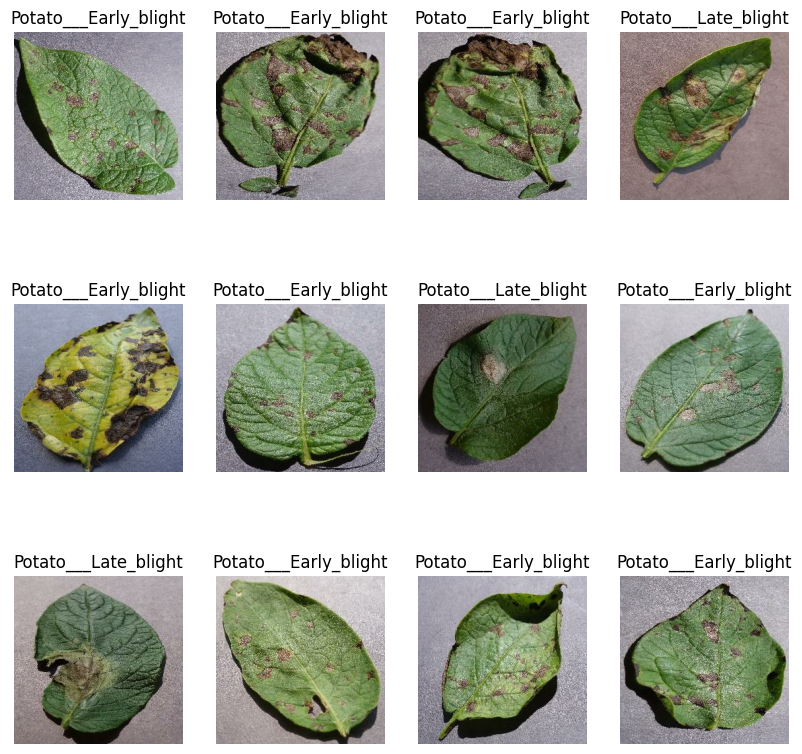

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

68

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 256)
])

In [62]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])


In [63]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [64]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])


C:\Users\chara\AppData\Local\Temp\ipykernel_18588\1205039245.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 22s 2us/step


In [65]:
model.summary()

ValueError: Undefined shapes are not supported.

In [67]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history_fine = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.6578 - loss: 0.7698 - val_accuracy: 0.4844 - val_loss: 1.0814
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8004 - loss: 0.5182 - val_accuracy: 0.6354 - val_loss: 0.8816
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.8764 - loss: 0.3697 - val_accuracy: 0.7760 - val_loss: 0.6812
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.9150 - loss: 0.2588 - val_accuracy: 0.8229 - val_loss: 0.5538
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9361 - loss: 0.2114 - val_accuracy: 0.8281 - val_loss: 0.4750
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9300 - loss: 0.1906 - val_accuracy: 0.8438 - val_loss: 0.3976
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9552 - loss: 0.1439 - val_accuracy: 0.9062 - val_loss: 0.3339
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9626 - loss: 0.1249 - val_accuracy: 0.9323 - v

In [68]:
# Save the Model
model_version = 4
model.save(f'models/{model_version}.keras')

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 560ms/step - accuracy: 0.4563 - loss: 0.9161 - val_accuracy: 0.5625 - val_loss: 0.8305
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.6451 - loss: 0.7690 - val_accuracy: 0.7448 - val_loss: 0.5900
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 592ms/step - accuracy: 0.7959 - loss: 0.4945 - val_accuracy: 0.7188 - val_loss: 0.5773
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 552ms/step - accuracy: 0.8317 - loss: 0.3852 - val_accuracy: 0.7760 - val_loss: 0.4655
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 523ms/step - accuracy: 0.8801 - loss: 0.3039 - val_accuracy: 0.8698 - val_loss: 0.3015
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 520ms/step - accuracy: 0.9082 - loss: 0.2256 - val_accuracy: 0.8750 - val_loss: 0.2506
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 535ms/step - accuracy: 0.9173 - loss: 0.2167 - val_accuracy: 0.9062 - val_loss: 0.2195
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - accuracy: 0.9314 - loss: 0.1795 - val_accu

In [36]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9883 - loss: 0.0348


In [37]:
scores

[0.04324972629547119, 0.984375]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [40]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [41]:
type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

50

In [43]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.895990788936615,
 0.7123541831970215,
 0.44881176948547363,
 0.39051565527915955,
 0.29621246457099915]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

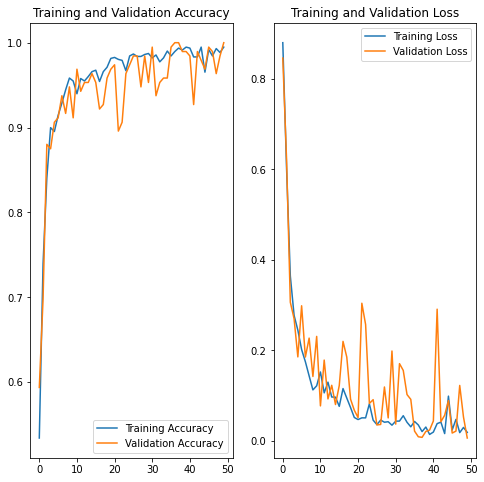

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
predicted label: Potato___Late_blight


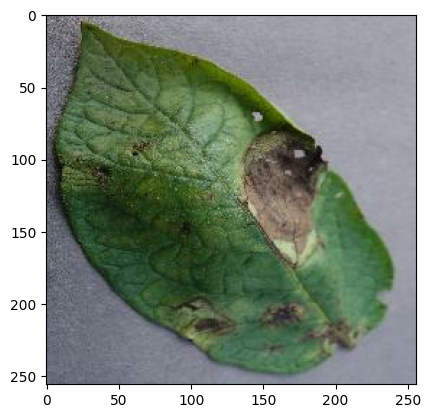

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


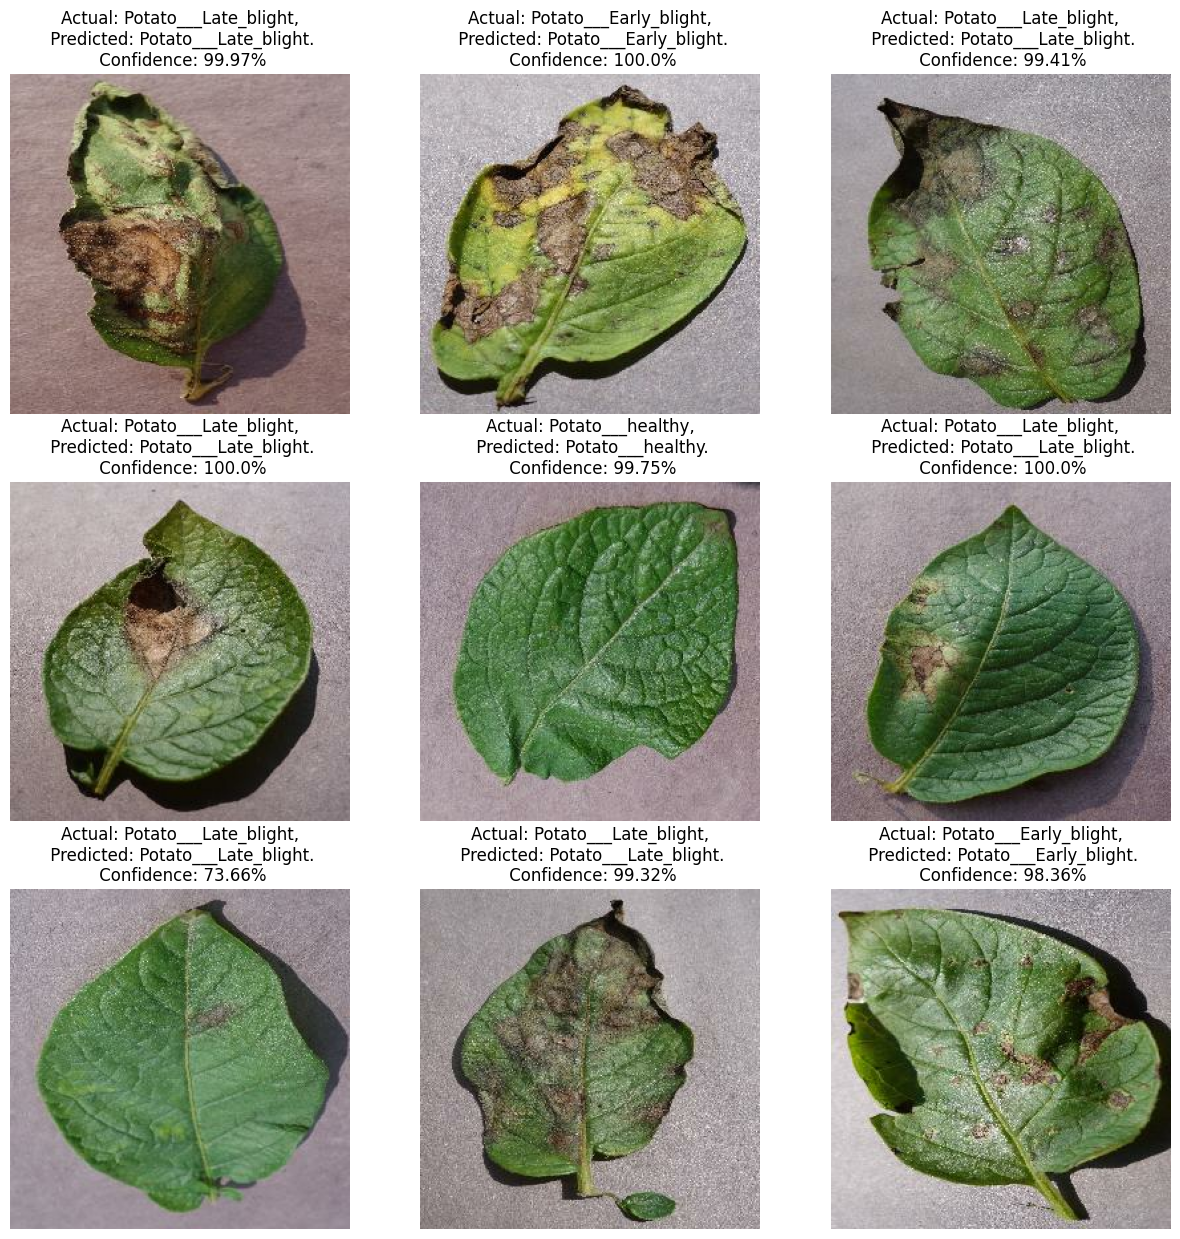

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [49]:
model.save(f'C:/New folder/VScode/python/potato-disease-classification/models/3.keras')

In [50]:
model.save("./potatoes.h5")

In [52]:
import json

# Save class names to a JSON file
class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)


In [54]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizing
    return img_array

In [57]:
from keras.preprocessing import image


def predict_image(model, img_path, class_names):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Example usage
img_path = r'potato\late1.JPG'
predicted_class, confidence = predict_image(model, img_path, class_names)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: Potato___Early_blight with confidence: 81.03%
